In [155]:
import pandas as pd
from datetime import datetime, timedelta

CSV Laden

In [156]:
import_file = "../Import/transactions_202403041139.csv"
date_columns = ["drive_in_at", "drive_out_at"]
df = pd.read_csv(import_file, parse_dates=date_columns)
df.head()

,gate_id_in,drive_in_at,drive_out_at,duration,id
0,68,2024-01-01 05:54:08,2024-01-01 15:41:13,587,3371593
1,68,2024-01-01 06:03:44,2024-01-01 06:08:09,5,3371607
2,68,2024-01-01 07:56:45,2024-01-01 11:48:14,232,3371761
3,68,2024-01-01 09:20:34,2024-01-01 09:25:12,5,3371881
4,68,2024-01-01 09:49:06,2024-01-01 11:35:33,106,3371931


Welche Parkplatz IDs gibt es?

In [157]:
df['gate_id_in'].drop_duplicates()

0        68
17088    70
23245    72
29638    78
Name: gate_id_in, dtype: int64

IDs der Parkplätze

In [158]:
parking_lots = [
    {
        'name': "Kaiservilla",
        'gate_id': 68
    },
    {
        'name': "Rechensteg",
        'gate_id': 70
    },
    {
        'name': "Traunkai",
        'gate_id': 72
    },
    {
        'name': "Kongress",
        'gate_id': 78
    },
]

In [159]:
ts_start = df['drive_in_at'].min()
ts_end = df['drive_out_at'].max()

print("Data available from", ts_start, "to", ts_end)

Data available from 2024-01-01 00:26:12 to 2024-03-04 07:43:17


In [160]:
def round_to_nearest_hour(date):
    if date.minute >= 30:
        # add an hour and remove mins and secs
        return date + timedelta(hours=1) - timedelta(minutes=date.minute, seconds=date.second)
    else:
        # remove mins and secs
        return date - timedelta(minutes=date.minute, seconds=date.second)


def get_data_by_hour(data):

    # key: the_hout, value: {delta, counter}
    data_by_hour = {}

    # going in
    for index, row in data.iterrows():
        hour = round_to_nearest_hour(row["drive_in_at"])
        if not hour in data_by_hour:
            data_by_hour[hour] = {
                'delta': 0,
                'counter': 0
            }
        data_by_hour[hour]['delta'] = data_by_hour[hour]['delta'] + 1
        #print("In", row["drive_in_at"], "around", hour, data_by_hour[hour])
        
    #going out
    for index, row in data.iterrows():
        hour = round_to_nearest_hour(row["drive_out_at"])
        if not hour in data_by_hour:
            data_by_hour[hour] = {
                'delta': 0,
                'counter': 0
            }
        data_by_hour[hour]['delta'] = data_by_hour[hour]['delta'] - 1
        #print("Out", row["drive_out_at"], "around", hour, data_by_hour[hour])
        
    # sort by date
    data_by_hour = dict(sorted(data_by_hour.items()))

    # sliding window counter algo
    current_count = 0
    for key in data_by_hour:
        current_count = current_count + data_by_hour[key]['delta']
        data_by_hour[key]['counter'] = current_count
        
    return data_by_hour

    

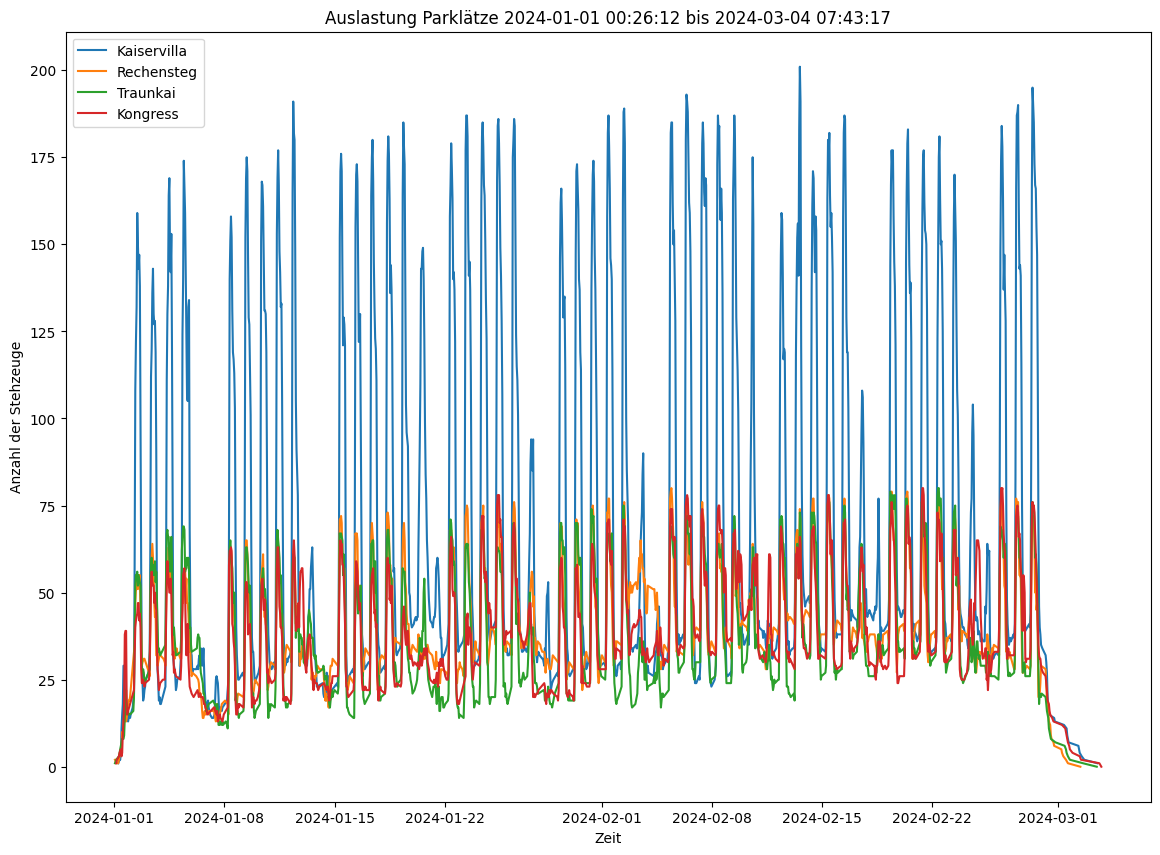

In [161]:
import matplotlib.pyplot as plt

def plot(df, start_date, end_date):
    
    filtered_df = df[ df['drive_in_at'].between(start_date, end_date) ]
    
    fig, ax = plt.subplots(figsize=(14, 10))  # Create a figure containing a single axes.
    ax.set_title(f"Auslastung Parklätze {start_date} bis {end_date}")
    ax.set_xlabel('Zeit')
    ax.set_ylabel('Anzahl der Stehzeuge')
    
    #for data in [p_kaiservilla, p_kongress]
    for parking_lot in parking_lots:
        #print(parking_lot)
        p_data = filtered_df[filtered_df['gate_id_in'] == parking_lot['gate_id']]
        data = get_data_by_hour(p_data)
        x = []
        y = []
        for key in data:
            if start_date < key < end_date:
                #print(key, data[key])
                x.append(key)
                y.append(data[key]['counter'])
                
        ax.plot(x, y, label=f"{parking_lot['name']}")
    
    ax.legend()



plot(df, ts_start, ts_end)

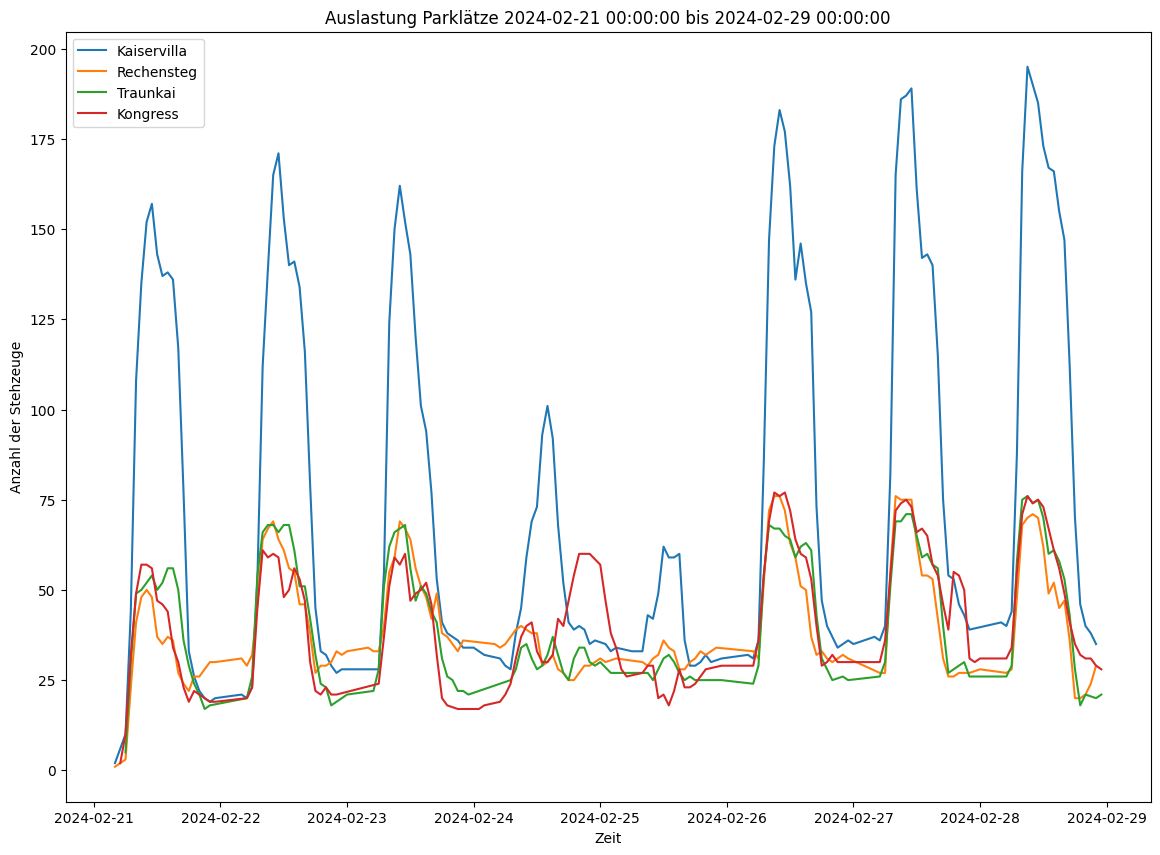

In [162]:
start_date = datetime(2024, 2, 21)
end_date = datetime(2024, 2, 29)
plot(df, start_date, end_date)

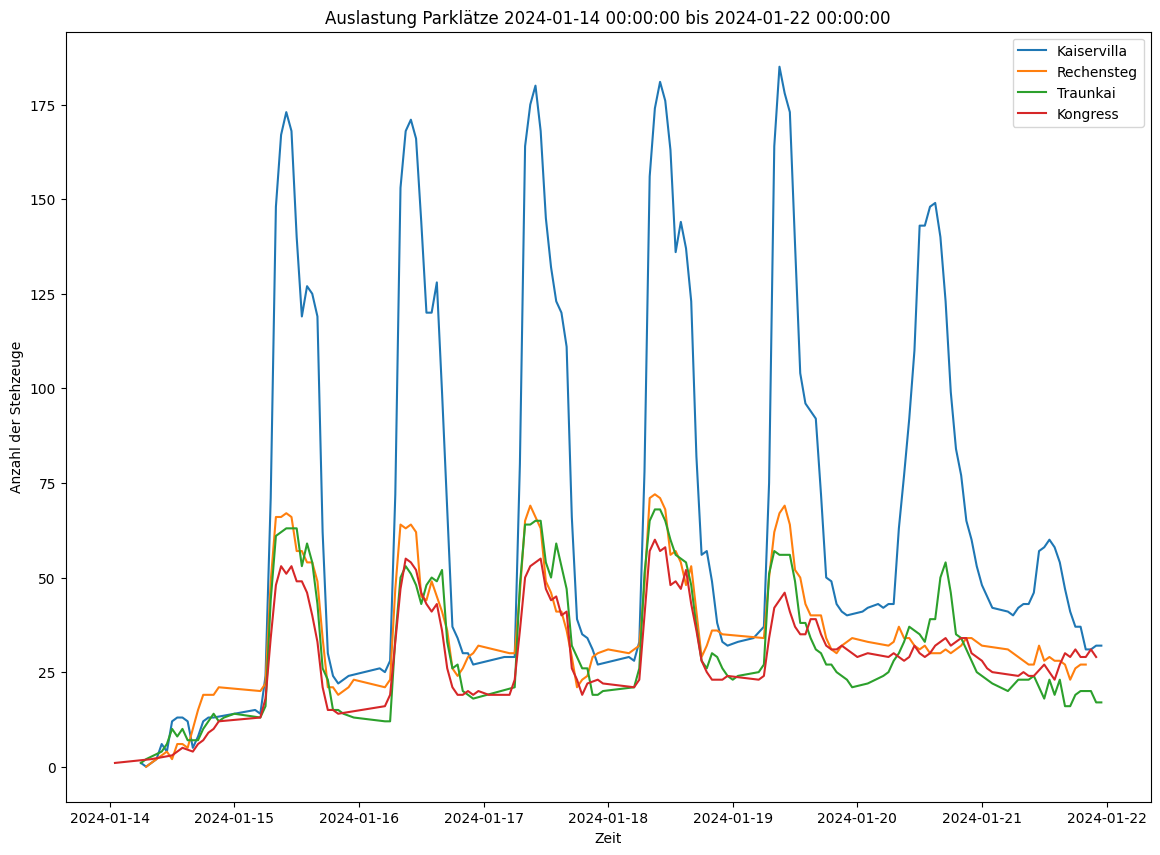

In [163]:
start_date = datetime(2024, 1, 14)
end_date = datetime(2024, 1, 22)
plot(df, start_date, end_date)